In [54]:
import networkx as nx
import os
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import plotly.express as px
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

## Data preparation

### Read graph processed in Gephi

In [7]:
G = nx.readwrite.graphml.read_graphml('../gephi/graph.graphml')

In [8]:
len(G.nodes)

26335

In [9]:
len(G.edges)

70403

In [10]:
nodes = dict(G.nodes(data=True))

In [2]:
# list(G.nodes)[0]

In [12]:
nodes[list(G.nodes)[0]]

{'In-Degree': 0,
 'Out-Degree': 16,
 'Degree': 16,
 'PageRank': 1.369306671996926e-05,
 'Clustering Coefficient': 0.07083333283662796,
 'Modularity Class': 0,
 'size': 14.434599,
 'r': 215,
 'g': 25,
 'b': 28,
 'x': -380.47852,
 'y': -3963.3545}

In [13]:
data_nodes = pd.DataFrame(nodes).T

In [1]:
# data_nodes.head()

### Read users profiles data

In [15]:
data_profiles = pd.read_csv('../data/23_17_38_2/all_users.csv')

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (1,2,3,11,23) have mixed types.Specify dtype option on import or set low_memory=False.



In [16]:
data_profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396862 entries, 0 to 396861
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       396862 non-null  int64  
 1   Unnamed: 0.1     396862 non-null  object 
 2   id               396861 non-null  object 
 3   conversation_id  396861 non-null  object 
 4   created_at       396861 non-null  object 
 5   date             396860 non-null  object 
 6   time             396860 non-null  object 
 7   timezone         396860 non-null  float64
 8   user_id          396861 non-null  float64
 9   username         396860 non-null  object 
 10  name             396860 non-null  object 
 11  place            18 non-null      object 
 12  tweet            396860 non-null  object 
 13  language         396859 non-null  object 
 14  mentions         396859 non-null  object 
 15  urls             396858 non-null  object 
 16  photos           396858 non-null  obje

### Plot graph

In [17]:
def plot_graphml_from_gephi(G, output_dir):

    #create traces
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0 = G.nodes[edge[0]]['x']
        y0 = G.nodes[edge[0]]['y']
        x1 = G.nodes[edge[1]]['x']
        y1 = G.nodes[edge[1]]['y']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x = G.nodes[node]['x']
        y = G.nodes[node]['y']
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            color=[],
            size=[],
            line_width=0))

    # nodes attributes
    node_colors = []
    node_sizes = []
    node_text = []

    for node in G.nodes(data=True):
        node_colors.append(''.join([
            'rgb(', str(node[1]['r']), ',', str(node[1]['g']), ',', str(node[1]['b']), ')'
        ]))
        node_sizes.append(node[1]['size'])
        node_text.append(node[0])

    node_trace.marker.color = node_colors
    node_sizes = np.array(node_sizes)
    node_sizes = np.interp(node_sizes, (node_sizes.min(), node_sizes.max()), (5, 50))
    node_trace.marker.size = node_sizes
    node_trace.text = node_text

    # plot
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
    fig.write_html(output_dir)

In [18]:
# plot_graphml_from_gephi(G, './graph_all.html')

### Communities distribution

In [19]:
data_nodes['Modularity Class'] = data_nodes['Modularity Class'].astype('category')
fig = px.histogram(data_nodes, x="Modularity Class")
fig.show()

### Filter users by community number

In [20]:
def get_nodes_filtered_by_community(c):
    filtered_nodes = list(filter(lambda n: n[1]['Modularity Class'] == c, G.nodes(data=True)))
    return list(map(lambda x: x[0], filtered_nodes))

In [21]:
users_A = get_nodes_filtered_by_community(0)
# plot_graphml_from_gephi(G.subgraph(users_A), './community_0.html')

In [22]:
users_B = get_nodes_filtered_by_community(11)
# plot_graphml_from_gephi(G.subgraph(users_B), './community_11.html')

In [23]:
users_C = get_nodes_filtered_by_community(14)
# plot_graphml_from_gephi(G.subgraph(users_C), './community_14.html')

In [24]:
f_nodes = users_A + users_B
# plot_graphml_from_gephi(G.subgraph(f_nodes), './community_0_11.html')

In [25]:
data_profiles_A = data_profiles[data_profiles['username'].isin(users_A)]
data_profiles_B = data_profiles[data_profiles['username'].isin(users_B)]

In [26]:
data_nodes = data_nodes.reset_index().rename(columns={'index': 'username'})
data_nodes_A = data_nodes[data_nodes['username'].isin(users_A)]
data_nodes_B = data_nodes[data_nodes['username'].isin(users_B)]

## Communities analysis

### Users total tweets number

In [27]:
plot_data_A = data_profiles_A[['username', 'id']].groupby('username').count()
plot_data_A['Group:'] = 'group A'
plot_data_B = data_profiles_B[['username', 'id']].groupby('username').count()
plot_data_B['Group:'] = 'group B'

fig = px.violin(plot_data_A.append(plot_data_B), y="id", color="Group:")

fig.update_layout(
    title='Users total tweets number',
    yaxis={
        'title':"User tweets number",
    }
)

fig.show()

### Tweets in time

In [28]:
plot_data_A = data_profiles_A[['date', 'id']].groupby('date').count().reset_index(inplace=False)
plot_data_B = data_profiles_B[['date', 'id']].groupby('date').count().reset_index(inplace=False)

fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_data_A['date'], y=plot_data_A['id']/len(users_A),
                    mode='lines',
                    name='group A',
                    marker={
                        'color':'blue'
                    }))
fig.add_trace(go.Scatter(x=plot_data_B['date'], y=plot_data_B['id']/len(users_B),
                    mode='lines',
                    name='group B',
                    marker={
                        'color':'red'
                    }))

fig.update_layout(
    barmode='overlay',
    title='Total tweets number per user in time',
    xaxis={
        'title':"Time",
    },
    yaxis={
        'title':"Tweets number per user ",
    }
)

fig.show()

### Tweets in day scope

In [29]:
plot_data_A = data_profiles_A[['time', 'id']].copy()
plot_data_A['hour'] = plot_data_A.apply(lambda x: int(x['time'][0:2]), axis=1)
plot_data_A = plot_data_A.groupby('hour').count().reset_index(inplace=False)

plot_data_B = data_profiles_A[['time', 'id']].copy()
plot_data_B['hour'] = plot_data_B.apply(lambda x: int(x['time'][0:2]), axis=1)
plot_data_B = plot_data_B.groupby('hour').count().reset_index(inplace=False)

fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_data_A['hour'], y=plot_data_A['id']/len(users_A),
                    mode='lines',
                    name='group A',
                    marker={
                        'color':'blue'
                    }
                ))
fig.add_trace(go.Scatter(x=plot_data_B['hour'], y=plot_data_B['id']/len(users_B),
                    mode='lines',
                    name='group B',
                    marker={
                        'color':'red'
                    }
                ))

fig.update_layout(
    barmode='overlay',
    title='Total tweets number per user in day scope',
    xaxis={
        'title':"Hours",
    },
    yaxis={
        'title':"Tweets number per user ",
    }
)

fig.show()

### In-degree histogram

In [30]:
plot_data_A = data_nodes_A[data_nodes_A['In-Degree'] > 1].copy()
plot_data_A['Group:'] = 'group A'
plot_data_B = data_nodes_B[data_nodes_B['In-Degree'] > 1].copy()
plot_data_B['Group:'] = 'group B'

fig = px.violin(plot_data_A.append(plot_data_B), y='In-Degree', color="Group:")

fig.update_layout(
    title='Nodes In-Degree (if in-degree > 1)',
    yaxis={
        'title':"In-Degree",
    }
)

fig.show()

### Out-degree histogram

In [31]:
plot_data_A = data_nodes_A.copy()
plot_data_A['Group:'] = 'group A'
plot_data_B = data_nodes_B.copy()
plot_data_B['Group:'] = 'group B'

fig = px.violin(plot_data_A.append(plot_data_B), y='Out-Degree', color="Group:")

fig.update_layout(
    title='Nodes Out-Degree',
    yaxis={
        'title':"Out-Degree",
    }
)

fig.show()

### PageRank

In [32]:
plot_data_A = data_nodes_A.copy()
plot_data_A['Group:'] = 'group A'
plot_data_B = data_nodes_B.copy()
plot_data_B['Group:'] = 'group B'

fig = px.violin(plot_data_A.append(plot_data_B), y='PageRank', color="Group:")

fig.update_layout(
    title='Nodes PageRank',
    yaxis={
        'title':"PAgeRank",
    }
)

fig.show()

### Top 10 most retweeted users

In [33]:
top_users_A = data_nodes_A.sort_values('Out-Degree', ascending=False)[['username', 'Out-Degree']].iloc[0:10].reset_index(inplace=False)
top_users_B = data_nodes_B.sort_values('Out-Degree', ascending=False)[['username', 'Out-Degree']].iloc[0:10].reset_index(inplace=False)
# df = pd.DataFrame(columns=['Most times retweeted users'])
# df['Most times retweeted users'].columns = ['Group A', 'Group B']
df = pd.DataFrame.from_dict({
    'Users A': top_users_A['username'],
    'Retweeted times A': top_users_A['Out-Degree'],
    'Users B': top_users_B['username'],
    'Retweeted times B': top_users_B['Out-Degree']
})
df.columns = pd.MultiIndex.from_product([['Most retweeted users'], ['Group A', 'Group B'], ['Users', 'Times retweeted']])
df

Most retweeted users                                                 
               Group A                          Group B                
                 Users Times retweeted            Users Times retweeted
0         PolsatNewsPL            42.0           AgaBak           237.0
1            PremierRP            39.0    RobertBiedron           173.0
2             tvp_info            35.0   everyday_loser           168.0
3       krzysztofbosak            34.0      partiarazem           166.0
4      R_A_Ziemkiewicz            34.0  givemethisjuice           155.0
5        PAPinformacje            32.0     PolaMatysiak           153.0
6       rzeczpospolita            30.0   heskillerqueer           153.0
7      cezarykrysztopa            29.0  batofthedungeon           145.0
8       RobertWinnicki            28.0        ancyminek           140.0
9          wybranowski            28.0        kgonciarz           138.0

### Most popular hashtags

In [34]:
def flat_list(t):
    flat_list = []
    for sublist in t:
        for item in sublist:
            flat_list.append(item)
    return flat_list
    8

def leaders(xs, top=10):
    counts = defaultdict(int)
    for x in xs:
        counts[x] += 1
    return sorted(counts.items(), reverse=True, key=lambda tup: tup[1])[:top]

def count(xs, top=10):
    counts = defaultdict(int)
    for x in xs:
        counts[x] += 1
    return counts

In [35]:
hashtags_A = list(map(lambda x: x[2:-2].split("', '"), data_profiles_A[data_profiles_A['hashtags'] != '[]']['hashtags']))
hashtags_A = flat_list(hashtags_A)
hashtags_A_sorted = leaders(hashtags_A)
hashtags_B = list(map(lambda x: x[2:-2].split("', '"), data_profiles_B[data_profiles_B['hashtags'] != '[]']['hashtags']))
hashtags_B = flat_list(hashtags_B)
hashtags_B_sorted = leaders(hashtags_B)

df = pd.DataFrame.from_dict({
    'Users A': list(map(lambda x: x[0], hashtags_A_sorted)),
    'Retweeted times A': list(map(lambda x: x[1], hashtags_A_sorted)),
    'Users B': list(map(lambda x: x[0], hashtags_B_sorted)),
    'Retweeted times B': list(map(lambda x: x[1], hashtags_B_sorted))
})
df.columns = pd.MultiIndex.from_product([['Most popular hashtags'], ['Group A', 'Group B'], ['Users', 'Times used']])
df

Most popular hashtags                                             
                 Group A                           Group B           
                   Users Times used                  Users Times used
0            wieszwięcej       1486         wyroknakobiety       3289
1            koronawirus       1428  trybunałkonstytucyjny       2096
2                covid19        609           piekłokobiet       1465
3                   pr24        565               topmodel       1387
4     koronawiruswpolsce        561            koronawirus        993
5  trybunałkonstytucyjny        520            harrypotter        789
6           konfederacja        422            wypierdalać        734
7               giertych        305        kobietadecyduje        710
8                prolife        245          falasprzeciwu        608
9           ruchnarodowy        235           zakazaborcji        563

In [36]:
def red_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return 'red'

def blue_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return 'blue'

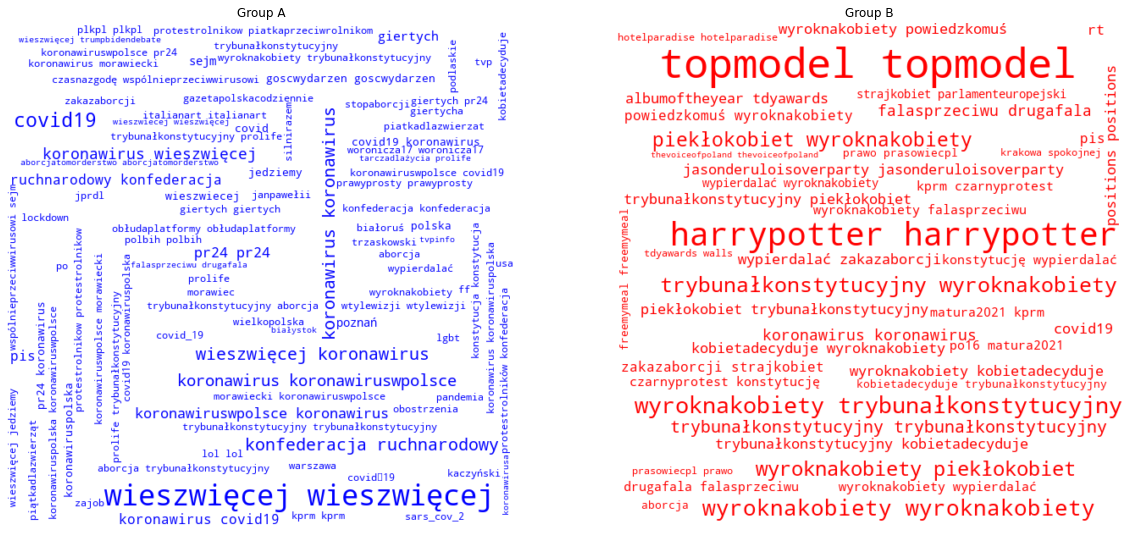

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(20,20))

wordcloud_A = WordCloud(
    width=600,
    height=600,
    min_font_size=10,
    background_color='white',
    color_func=blue_color_func
).generate(' '.join(hashtags_A))

axs[0].imshow(wordcloud_A, interpolation="bilinear")
axs[0].axis("off")
axs[0].title.set_text('Group A')

wordcloud_B = WordCloud(
    width=600,
    height=600,
    min_font_size=10,
    background_color='white',
    color_func=red_color_func
).generate(' '.join(hashtags_B))

axs[1].imshow(wordcloud_B, interpolation="bilinear")
axs[1].axis("off")
axs[1].title.set_text('Group B')

plt.show()

### Polarity in time

In [38]:
plot_data_A = data_profiles_A[['date', 'polarity']].groupby('date').mean().reset_index(inplace=False)
plot_data_B = data_profiles_B[['date', 'polarity']].groupby('date').mean().reset_index(inplace=False)

fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_data_A['date'], y=plot_data_A['polarity'],
                    mode='lines',
                    name='group A',
                    marker={
                        'color':'blue'
                    }))
fig.add_trace(go.Scatter(x=plot_data_B['date'], y=plot_data_B['polarity']/len(users_B),
                    mode='lines',
                    name='group B',
                    marker={
                        'color':'red'
                    }))

fig.update_layout(
    barmode='overlay',
    title='Polarity in time',
    xaxis={
        'title':"Time",
    },
    yaxis={
        'title':"Polarity",
    }
)

fig.show()

### Polarity violine plots

In [39]:
plot_data_A = data_profiles_A[['username', 'polarity']].groupby('username').mean().reset_index(inplace=False)
plot_data_A['Group:'] = 'group A'
plot_data_B = data_profiles_B[['username', 'polarity']].groupby('username').mean().reset_index(inplace=False)
plot_data_B['Group:'] = 'group B'

fig = px.violin(plot_data_A.append(plot_data_B), y="polarity", color="Group:")

fig.update_layout(
    title='Mean users polarity',
    yaxis={
        'title':"Polarity",
    }
)

fig.show()

## Classification task

### Data preparation

In [40]:
others_hash = ['piatkadlazwierzat', 'piatkaprzeciwrolnikom', 'protestrolnikow']

In [41]:
data = pd.DataFrame(columns=[
    'mean_polarity',
    'top_hash_A',
    'top_hash_B',
    'top_retweeted_A',
    'top_retweeted_B',
    'tweets_per_day',
    'in_degree',
    'out_degree',
    'others_hash',
    'class'
])

In [42]:
def get_row(user, c):
    user_data = data_profiles[data_profiles['username'] == user]
    user_node = data_nodes[data_nodes['username'] == user]
    user_hashtags = flat_list(list(map(lambda x: x[2:-2].split("', '"), user_data[user_data['hashtags'] != '[]']['hashtags'])))
    
    return {
        'mean_polarity': user_data['polarity'].mean(),
        'top_hash_A': len([h for h in user_hashtags if h in list(map(lambda x: x[0], hashtags_A_sorted))]),
        'top_hash_B': len([h for h in user_hashtags if h in list(map(lambda x: x[0], hashtags_B_sorted))]),
        'others_hash': len(list(set(user_hashtags).intersection(others_hash))),
        'top_retweeted_A': len([u for u in list(user_data['retweeted_user']) if u in list(top_users_A['username'])]),
        'top_retweeted_B': len([u for u in list(user_data['retweeted_user']) if u in list(top_users_B['username'])]),
        'tweets_per_day': len(user_data)/11,
        'in_degree': user_node['In-Degree'].iloc[0],
        'out_degree': user_node['Out-Degree'].iloc[0],
        'class': c
    }

In [43]:
# data.to_csv('../data/23_17_38_2/data_class.csv')

In [44]:
data = pd.read_csv('../data/23_17_38_2/data_class.csv', index_col=0)

In [45]:
data.head()

mean_polarity  top_hash_A  top_hash_B  top_retweeted_A  top_retweeted_B  \
0       0.042572         7.0         3.0              2.0              0.0   
1       0.010550        10.0         4.0              8.0              0.0   
2       0.052760         8.0         6.0              1.0              1.0   
3       0.064894         5.0         1.0              0.0              0.0   
4       0.067810        19.0        14.0             54.0              0.0   

   tweets_per_day  in_degree  out_degree  others_hash  class  
0       50.181818       34.0         0.0          1.0    0.0  
1       19.818182      118.0         3.0          1.0    0.0  
2       86.727273      112.0         0.0          0.0    0.0  
3       17.090909       39.0         0.0          0.0    0.0  
4       79.545455      281.0        10.0          0.0    0.0

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1559 entries, 0 to 1558
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_polarity    1559 non-null   float64
 1   top_hash_A       1559 non-null   float64
 2   top_hash_B       1559 non-null   float64
 3   top_retweeted_A  1559 non-null   float64
 4   top_retweeted_B  1559 non-null   float64
 5   tweets_per_day   1559 non-null   float64
 6   in_degree        1559 non-null   float64
 7   out_degree       1559 non-null   float64
 8   others_hash      1559 non-null   float64
 9   class            1559 non-null   float64
dtypes: float64(10)
memory usage: 134.0 KB


In [47]:
data['class'] = data['class'].astype('category')
fig = px.histogram(data, x="class")
fig.update_layout(
    title='Class distribution',
    xaxis={
        'title':"Class",
    },
    yaxis={
        'title':"Count",
    }
)
fig.show()

In [48]:
d = data['tweets_per_day']
removed_outliers = d.between(d.quantile(.05), d.quantile(.95))
data = data[removed_outliers]

In [49]:
fig = px.histogram(data, x="class")
fig.update_layout(
    title='Class distribution after removing outliers by tweets_per_day values',
    xaxis={
        'title':"Class",
    },
    yaxis={
        'title':"Count",
    }
)
fig.show()

In [50]:
data_test = data[data['class'] == 0].sample(50)
data_test = data_test.append(data[data['class'] == 1].sample(50))
data_train = data.drop(data_test.index)

X_train = data_train.drop(columns='class')
y_train = data_train['class']

X_test = data_test.drop(columns='class')
y_test = data_test['class']

### Model

In [51]:
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

In [55]:
print(accuracy_score(y_test, y_pred))

0.76


In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.64      0.73        50
         1.0       0.71      0.88      0.79        50

    accuracy                           0.76       100
   macro avg       0.78      0.76      0.76       100
weighted avg       0.78      0.76      0.76       100



In [53]:
fig = go.Figure([go.Bar(x=X_train.columns, y=tree.feature_importances_)])
fig.update_layout(
    title='Features importance',
    xaxis={
        'title':"Feature",
    },
    yaxis={
        'title':"Importance",
    }
)
fig.show()